Fixed probability counter : 1 / 16 : aula 09

Space-Saving Count : aula 11

In [84]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,              # If you want to use LaTeX fonts in text
    "font.family": "serif",           # IEEE uses Times New Roman-like fonts
    "font.size": 12,                   # General font size for IEEE format
    "axes.labelsize": 12,              # Axis labels font size
    "legend.fontsize": 11,             # Legend font size
    "xtick.labelsize": 11,             # X-axis tick labels font size
    "ytick.labelsize": 11,             # Y-axis tick labels font size
    "figure.figsize": (5, 5*0.8),
    "savefig.dpi": 1200,               # DPI for high-quality PNG/JPEG
})

## exact counters AND probabilistic counters

In [85]:
def count_words(book, use_exact=True, use_approximate=True):
    with open(book, "r") as f:
        text = f.read()
    words = text.split()

    exact_counter = {}
    approximate_counter = {}
    for word in words:

        if use_exact:
            # exact counter
            if word in exact_counter:
                exact_counter[word] += 1
            else:
                exact_counter[word] = 1

        if use_approximate:
            # approximate counter with 1/16 probability
            if random.random() < 1/16:
                if word in approximate_counter:
                    approximate_counter[word] += 1
                else:
                    approximate_counter[word] = 1
            else:
                pass
        
    exact_counter = {k: v for k, v in sorted(exact_counter.items(), key=lambda item: item[1], reverse=True)}
    approximate_counter = {k: v*16 for k, v in sorted(approximate_counter.items(), key=lambda item: item[1], reverse=True)}
    return (exact_counter,
            approximate_counter)

In [86]:
#exactEN, approximateEN = count_words("books/pinocchio_en.txt", use_exact=True, use_approximate=True)
#exactIT, approximateIT = count_words("books/pinocchio_it.txt", use_exact=True, use_approximate=True)
#exactFI, approximateFI = count_words("books/pinocchio_fi.txt", use_exact=True, use_approximate=True)

In [87]:
if False:
    df_exact = {("EN", "word"): [],
                ("EN", "count"): [],
                ("IT", "word"): [],
                ("IT", "count"): [],
                ("FI", "word"): [],
                ("FI", "count"): []}

    for k, v in exactEN.items():
        df_exact[("EN", "word")].append(k)
        df_exact[("EN", "count")].append(int(v))

    for k, v in exactIT.items():
        df_exact[("IT", "word")].append(k)
        df_exact[("IT", "count")].append(int(v))

    for k, v in exactFI.items():
        df_exact[("FI", "word")].append(k)
        df_exact[("FI", "count")].append(int(v))

    total_rows = max(len(df_exact[("EN", "word")]), len(df_exact[("IT", "word")]), len(df_exact[("FI", "word")]))
    for i in range(total_rows):
        if i >= len(df_exact[("EN", "word")]):
            df_exact[("EN", "word")].append(np.nan)
            df_exact[("EN", "count")].append(np.nan)
        if i >= len(df_exact[("IT", "word")]):
            df_exact[("IT", "word")].append(np.nan)
            df_exact[("IT", "count")].append(np.nan)
        if i >= len(df_exact[("FI", "word")]):
            df_exact[("FI", "word")].append(np.nan)
            df_exact[("FI", "count")].append(np.nan)

    df_exact = pd.DataFrame(df_exact)
    #df_exact.to_excel("results/exact_counts.xlsx")
    print("Exact counts saved to results/exact_counts.xlsx")

In [88]:
if False:
    df_prob = {}
    for _ in range(20):
        df_prob[("EN", f"word_{_}")] = []
        df_prob[("EN", f"count_{_}")] = []
        df_prob[("IT", f"word_{_}")] = []
        df_prob[("IT", f"count_{_}")] = []
        df_prob[("FI", f"word_{_}")] = []
        df_prob[("FI", f"count_{_}")] = []

        exactEN, approximateEN = count_words("books/pinocchio_en.txt", use_exact=False, use_approximate=True)
        exactIT, approximateIT = count_words("books/pinocchio_it.txt", use_exact=False, use_approximate=True)
        exactFI, approximateFI = count_words("books/pinocchio_fi.txt", use_exact=False, use_approximate=True)

        for k, v in approximateEN.items():
            df_prob[("EN", f"word_{_}")].append(k)
            df_prob[("EN", f"count_{_}")].append(int(v))
        
        for k, v in approximateIT.items():
            df_prob[("IT", f"word_{_}")].append(k)
            df_prob[("IT", f"count_{_}")].append(int(v))
        
        for k, v in approximateFI.items():
            df_prob[("FI", f"word_{_}")].append(k)
            df_prob[("FI", f"count_{_}")].append(int(v))
    
    total_rows = 0
    for k in df_prob.keys():
        total_rows = max(total_rows, len(df_prob[k]))
    for k in df_prob.keys():
        for i in range(total_rows):
            if i >= len(df_prob[k]):
                df_prob[k].append(np.nan)
    df_prob = pd.DataFrame(df_prob)

    order_h0 = ["EN", "IT", "FI"]
    order_h1 = [(f"word_{_}", f"count_{_}") for _ in range(20)]
    order = []
    for h0 in order_h0:
        for h1w, h1c in order_h1:
            order.append((h0, h1w))
            order.append((h0, h1c))
    df_prob = df_prob[order]
    #df_prob.to_excel("results/approximate_counts.xlsx")
    print("Approximate counts saved to results/approximate_counts.xlsx")

## space-saving counters

In [89]:
class SpaceSavingCounter:
    """
    A class to implement the Space-Saving algorithm for approximate counting of elements.

    Attributes:
    -----------
    k : int
        The maximum number of elements to keep track of.
    table : dict
        A dictionary to store elements and their approximate counts.

    Methods:
    --------
    __init__(k):
        Initializes the SpaceSavingCounter with a specified maximum number of elements.
    
    process(element):
        Processes an element by either incrementing its count if it exists in the table,
        adding it to the table if there is space, or evicting the element with the smallest
        count and inserting the new element with an incremented count.
    
    get_counts():
        Returns the current table of elements and their approximate counts.
    """
    def __init__(self, k):
        self.k = k
        self.table = {}  

    def process(self, element):
        # If element is already in the table, increment its count
        if element in self.table:
            self.table[element] += 1
        else:
            # If there is space in the table, add the element with count 1
            if len(self.table) < self.k:
                self.table[element] = 1
            else:
                # If the table is full, find the element with the smallest count
                min_element = min(self.table, key=self.table.get)
                min_count = self.table[min_element]
                # Evict the element with the smallest count and insert the new element
                del self.table[min_element]  # Remove the element with the smallest count
                self.table[element] = min_count + 1  # Insert the new element with incremented count

    def get_counts(self):
        return self.table
    
    
def count_words_SS(book, k):
    with open(book, "r") as f:
        text = f.read()
    words = text.split()

    counter = SpaceSavingCounter(k)
    for word in words:
        counter.process(word)

    counter = {k: v for k, v in sorted(counter.get_counts().items(), key=lambda item: item[1], reverse=True)}

    return counter

In [90]:
def space_saving_onlyvalues(book, k):
    with open(book, "r") as f:
        text = f.read()
    words = text.split()
    n = len(words)

    space_saving = SpaceSavingCounter(k)
    for word in words:
        space_saving.process(word)
        
    return (list(space_saving.get_counts().values()), n)

#ss, n = space_saving_onlyvalues("books/pinocchio_en.txt", 100)

#set(ss)

como quero top10: ...

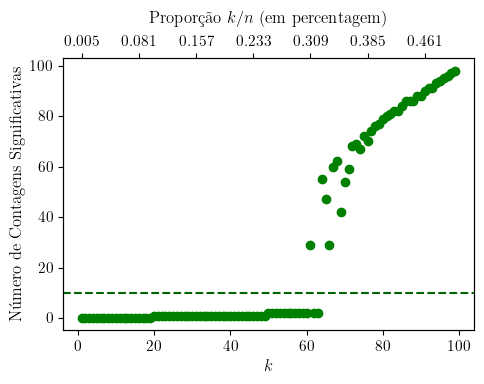

In [91]:
# ver a que partir de k se comeca a ter precisao
plot1_y = []
ks = range(1, 100)

for k in ks:
    ss, n = space_saving_onlyvalues("books/pinocchio_it.txt", k)
    mas_contagens = 0
    for s in ss:
        if s in range(int(n/k * 0.99), int(n/k * 1.01)):
            mas_contagens += 1
    # plot1
    plot1_y.append(len(ss) - mas_contagens)

# Create the main plot
fig, ax1 = plt.subplots()

# Plot the primary scatter plot
ax1.scatter(ks, plot1_y, color="green")
plt.axhline(y=10, color="darkgreen", linestyle="--")

ax1.set_xlabel("$k$")
ax1.set_ylabel("Número de Contagens Significativas")

# Create a secondary x-axis
NUMBER_OF_TICKS = 15
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())  # Align the second x-axis with the primary one
ax2.set_xticks(ks[::NUMBER_OF_TICKS])  # Match the ticks to the primary axis
ax2.set_xticklabels(np.round( np.array(ks)[::NUMBER_OF_TICKS] * 100 / n, 3 ))  # Label the secondary x-axis ticks
ax2.set_xlabel("Proporção $k/n$ (em percentagem)", labelpad=9)

plt.tight_layout()
#plt.savefig("assets/ss_signcount.png", transparent=True)
plt.show() 


In [92]:
ks = range(1, 500)
books = ["books/pinocchio_en.txt", "books/pinocchio_it.txt", "books/pinocchio_fi.txt"]
for book in books:
    for k in ks:
        ss, n = space_saving_onlyvalues(book, k)
        mas_contagens = 0
        for s in ss:
            if s in range(int(n/k * 0.99), int(n/k * 1.01)):
                mas_contagens += 1
        if len(ss) - mas_contagens > 10:
            print(f"o {book}, k = {k} tem mais de 10 contagens significativas, prop: {k/n * 100}")
            break

o books/pinocchio_en.txt, k = 59 tem mais de 10 contagens significativas, prop: 0.34440488004202907
o books/pinocchio_it.txt, k = 61 tem mais de 10 contagens significativas, prop: 0.3092992597099686
o books/pinocchio_fi.txt, k = 67 tem mais de 10 contagens significativas, prop: 0.37075978086436834


In [93]:
if True:
    for k in [10, 70, "%", 150]:
        df = {("EN", "word"): [],
              ("EN", "count"): [],
              ("IT", "word"): [],
              ("IT", "count"): [],
              ("FI", "word"): [],
              ("FI", "count"): []}
        lang = ["EN", "IT", "FI"]
        books = ["books/pinocchio_en.txt", "books/pinocchio_it.txt", "books/pinocchio_fi.txt"]

        if k == "%":
            for i in range(3):
                book = books[i]
                with open(book, "r") as f:
                    text = f.read()
                    words = text.split()
                    n = len(words)
                k = int(n * 0.4 / 100)
                print(f"Using k = {k} for book {book}")
                results = count_words_SS(books[i], k)
                for key, v in results.items():
                    df[(lang[i], "word")].append(key)
                    df[(lang[i], "count")].append(int(v))

            total_rows = max(len(df[("EN", "word")]), len(df[("IT", "word")]), len(df[("FI", "word")]))
            for i in range(total_rows):
                if i >= len(df[("EN", "word")]):
                    df[("EN", "word")].append(np.nan)
                    df[("EN", "count")].append(np.nan)
                if i >= len(df[("IT", "word")]):
                    df[("IT", "word")].append(np.nan)
                    df[("IT", "count")].append(np.nan)
                if i >= len(df[("FI", "word")]):
                    df[("FI", "word")].append(np.nan)
                    df[("FI", "count")].append(np.nan)
            
            df = pd.DataFrame(df)
            df.to_excel("results/SSpc_counts.xlsx")
            print("SSpc counts saved to results/SSpc_counts.xlsx")
            print("---------------")

        else:
            for i in range(3):
                results = count_words_SS(books[i], k)
                for key, v in results.items():
                    df[(lang[i], "word")].append(key)
                    df[(lang[i], "count")].append(int(v))


            df = pd.DataFrame(df)
            df.to_excel(f"results/SS{k}_counts.xlsx")
            print(f"SS{k} counts saved to results/SS{k}_counts.xlsx")
            print("---------------")

SS10 counts saved to results/SS10_counts.xlsx
---------------
SS70 counts saved to results/SS70_counts.xlsx
---------------
Using k = 68 for book books/pinocchio_en.txt
Using k = 78 for book books/pinocchio_it.txt
Using k = 72 for book books/pinocchio_fi.txt
SSpc counts saved to results/SSpc_counts.xlsx
---------------
SS150 counts saved to results/SS150_counts.xlsx
---------------
